In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#Training algorithms import
from sklearn.ensemble import RandomForestClassifier


plt.style.use("fivethirtyeight")

# Evaluation and training imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [2]:
df = pd.read_csv("data\sensor_data.csv", parse_dates=True, header=None) 
df.columns = ["Datetime","Temperature", "Humidity" , "Pressure", "Altitude" ,"CO" ,"CO2" ,"NH4", "PM1.0" ,"PM2.5", "PM10.0"]
df['Datetime'] = pd.to_datetime(df["Datetime"], format='%Y-%m-%d %H:%M:%S')

quantities = ['Temperature', 'Rel. Humidity', 'Pressure', 'CO', r'CO$_2$', r'NH$_3$', r'PM$_{1}$', 
                  'PM$_{2.5}$', 'PM$_{10}$']
units = [r'$^o$C','%', 'hPa','ppm','ppm','ppm',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ']
df = df.set_index("Datetime").drop(['Altitude'], axis=1)
df['Pressure'] = df['Pressure']/100

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130081 entries, 2023-06-05 10:12:43 to 2023-07-23 21:56:40
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperature  130081 non-null  float64
 1   Humidity     130081 non-null  float64
 2   Pressure     130081 non-null  float64
 3   CO           130081 non-null  float64
 4   CO2          130081 non-null  float64
 5   NH4          130081 non-null  float64
 6   PM1.0        130081 non-null  int64  
 7   PM2.5        130081 non-null  int64  
 8   PM10.0       130081 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 9.9 MB


In [96]:
# Adding an hour feature to the dataset 
df["hour"] = df.index.hour
df["dayofweek"] = df.index.day_of_week

def add_features(dat):
    dat = dat.copy()
    dat["hour"] = dat.index.hour
    dat["dayofweek"] = dat.index.dayofweek
    return dat

In [89]:
part_mt = df[["PM1.0" ,"PM2.5", "PM10.0", "hour", "dayofweek"]]


part_mt.head()

,PM1.0,PM2.5,PM10.0,hour,dayofweek
Datetime,,,,,
2023-06-05 10:12:43,9,14,16,10,0
2023-06-05 10:12:53,9,13,13,10,0
2023-06-08 12:34:49,6,6,8,12,3
2023-06-08 12:34:49,6,6,8,12,3
2023-06-08 12:34:50,6,6,8,12,3


### For PM1.0

In [91]:
#Splitting of train and test data
X = part_mt.drop(["PM1.0", "PM2.5", "PM10.0"], axis=1)
y = part_mt[["PM1.0", "PM2.5", "PM10.0"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [92]:
# Training the model
part_mt_model = RandomForestClassifier()
part_mt_model.fit(X_train, y_train)

RandomForestClassifier()

In [93]:
joblib.dump(part_mt_model, "models/part_mt.sav")

['models/part_mt.sav']

<AxesSubplot: xlabel='Datetime'>

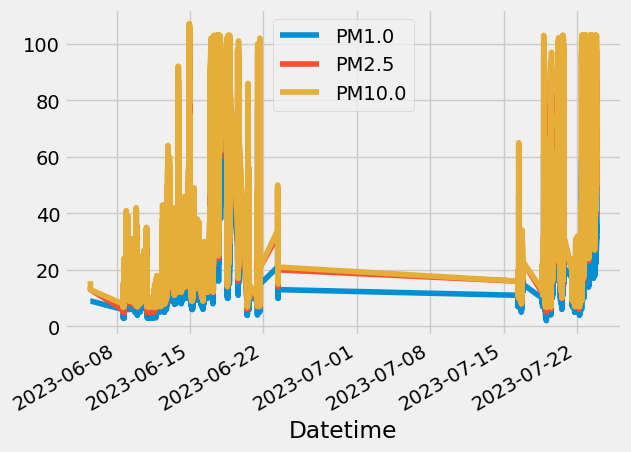

In [95]:
part_mt.drop(["hour", "dayofweek"], axis=1).plot()

In [76]:
#Predicting values with a time interval 
start = pd.Timestamp("2023-07-28 08:00:00")
end = pd.Timestamp("2023-08-05 20:00:00")

#Creating a datetime range for predictions with a step of 10min
pre_datetimes = pd.date_range(start, end, freq="10T")

In [106]:
#Creating a new dataframe to hold predicted values
pre_df = pd.DataFrame({"Datetime" : pre_datetimes})
pre_df = pre_df.set_index("Datetime")
pre_df = add_features(pre_df)

# pre_df.to_csv("predict_pm1.csv", header="True")

In [107]:
pre_df.head()

,hour,dayofweek
Datetime,,
2023-07-28 08:00:00,8,4
2023-07-28 08:10:00,8,4
2023-07-28 08:20:00,8,4
2023-07-28 08:30:00,8,4
2023-07-28 08:40:00,8,4


In [108]:
predictions = part_mt_model.predict(pre_df)

In [112]:
pre_df[["PM1.0", "PM2.5", "PM10.0"]] = predictions

In [115]:
final_predictions = pre_df.drop(["hour", "dayofweek"], axis=1)

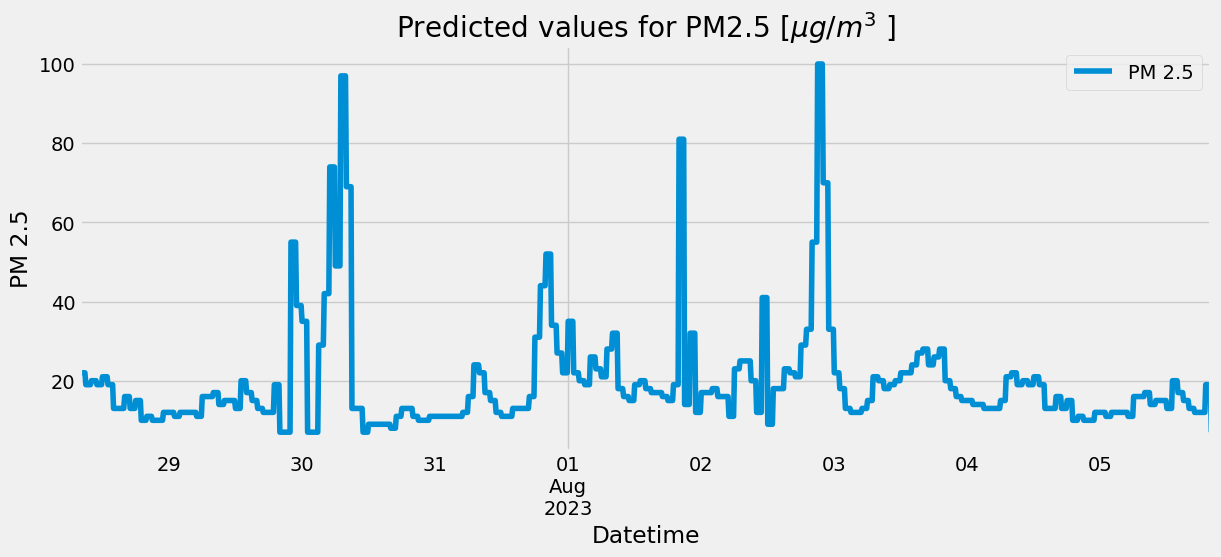

In [130]:
pm2_5 = final_predictions["PM2.5"]
pm1_0 = final_predictions["PM1.0"]

pm2_5.plot(figsize=(13, 5), label="PM 2.5", title=f"Predicted values for PM2.5 [{units[6]}]", ylabel="PM 2.5")

plt.legend()

<AxesSubplot: title={'center': 'Predicted values for PM1.0 [$\\mu g/m^3$ ]'}, xlabel='Datetime', ylabel='PM 1.0'>

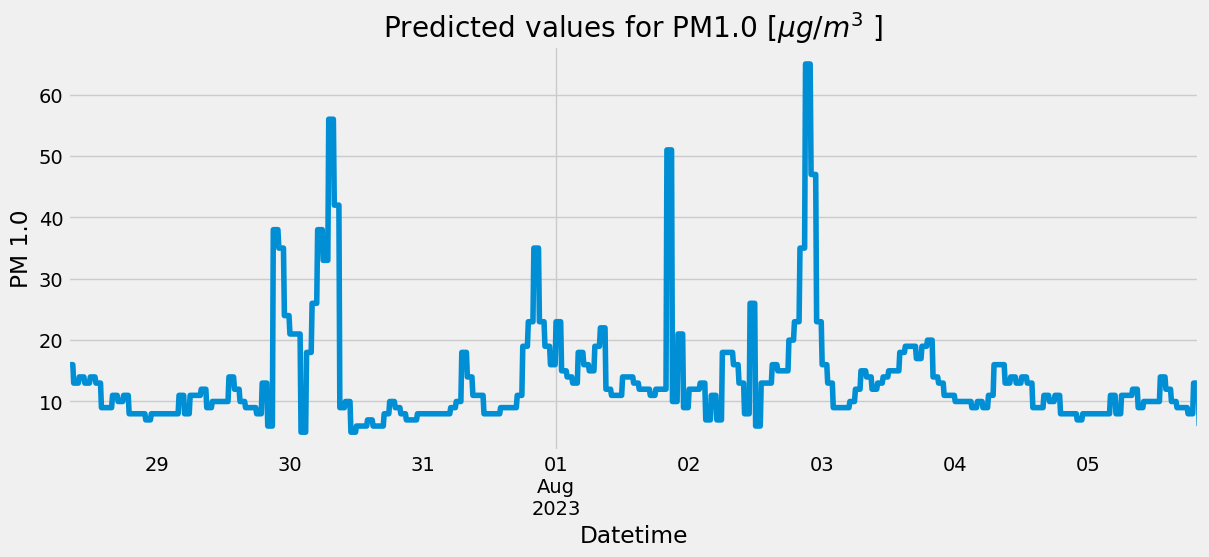

In [131]:
pm1_0 = final_predictions["PM1.0"]

pm1_0.plot(figsize=(13, 5), title=f"Predicted values for PM1.0 [{units[6]}]", ylabel="PM 1.0")


In [118]:
final_predictions.to_csv("final_predict.csv", header=True)